In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import h5py

plt.rcParams["figure.figsize"] = (10,8)

In [2]:
hf = h5py.File('gammaray_lab4.h5', 'r')

In [3]:
hf.keys()

<KeysViewHDF5 ['data']>

In [4]:
data = np.array(hf.get('data'))

In [5]:
data[:,0]

array([9.40680016e+08, 3.15000000e+02, 4.50000000e+01, 1.00000000e+01])

In [6]:
hf.close()

### Problem 1.
#### 1)

In [7]:
hf = h5py.File('gammaray_lab4.h5', 'r')
data = np.array(hf.get('data'))

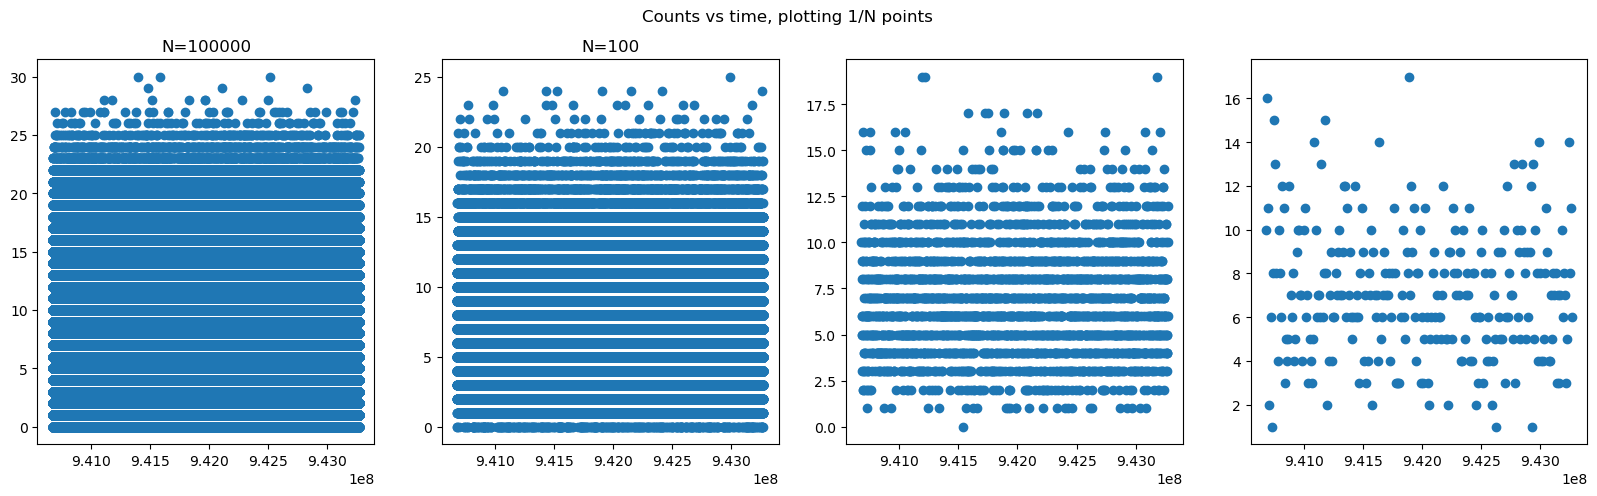

In [8]:
fig, ax = plt.subplots(1,4, figsize=(20,5))
ax[0].scatter(data[0,:], data[3,:])
ax[0].set_title('N=1')
ax[1].scatter(data[0,::100], data[3,::100])
ax[1].set_title('N=100')
ax[2].scatter(data[0,::10000], data[3,::10000])
ax[0].set_title('N=10000')
ax[3].scatter(data[0,::100000], data[3,::100000])
ax[0].set_title('N=100000')
plt.suptitle('Counts vs time, plotting 1/N points')
plt.show()

Plotting all of the points fills the plot and makes it impossible to see any features. When plotting only some of the data points, it does look like there is some kind of periodic variability in the background. There doesn't appear to be any data contamination, as there aren't any counts beyond ~30, so there aren't any extreme outliers.

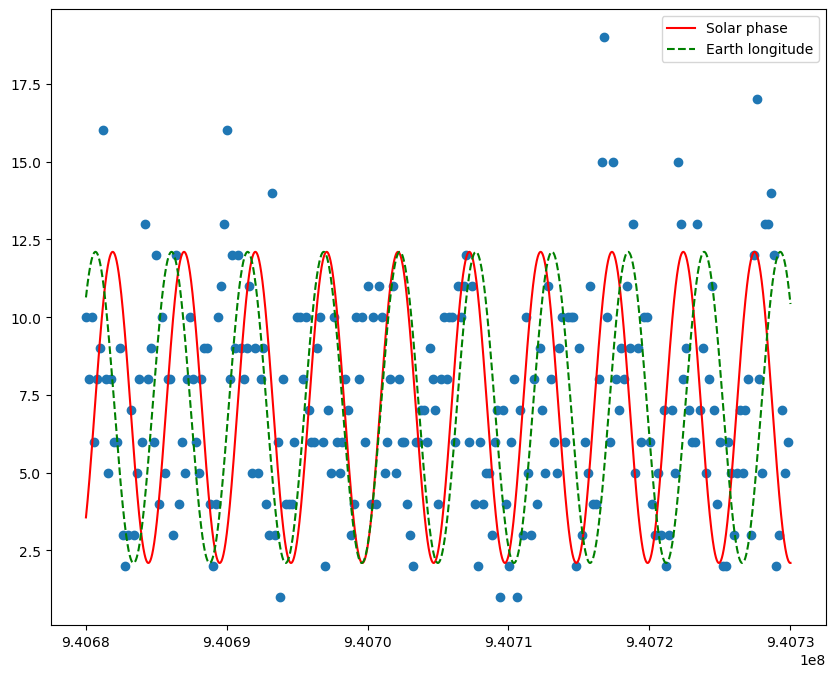

In [9]:
plt.scatter(data[0,:500000:2000], data[3,:500000:2000])
plt.plot(data[0,:500000], np.sin(data[1,:500000]*2*np.pi/360)*5 + np.mean(data[3,:]), c='r', label='Solar phase')
plt.plot(data[0,:500000], np.sin(data[2,:500000]*2*np.pi/360)*5 + np.mean(data[3,:]), c='g', linestyle='--', label='Earth longitude')
plt.legend()
plt.show()

The solar phase and Earth longitude both appear to have a regular period, but they don't have the same period and phase. It's hard to tell from this plot which, if either, is the contributing factor for the variability of the distribution.

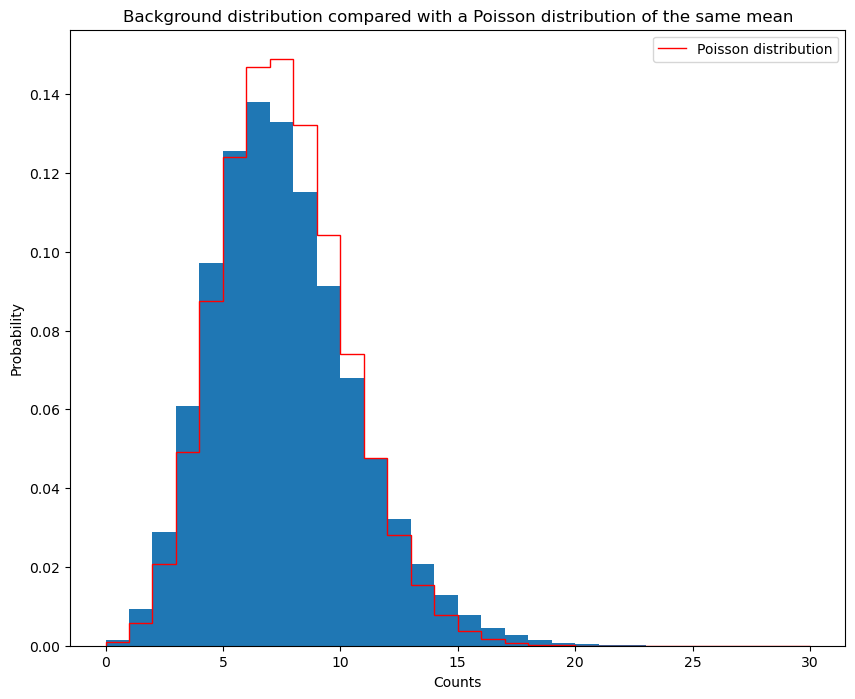

In [10]:
h, bins, patches = plt.hist(data[3,:], density=True, bins=30)
mu = np.mean(data[3,:])
x = np.arange(0,30)
plt.stairs(stats.poisson.pmf(x,mu), color='r', label='Poisson distribution')
plt.title('Background distribution compared with a Poisson distribution of the same mean')
plt.ylabel('Probability')
plt.xlabel('Counts')
plt.legend()
plt.show()


The distribution is close to, but not quite, a Poisson distribution with a mean equal to the mean of the counts.

#### 2)

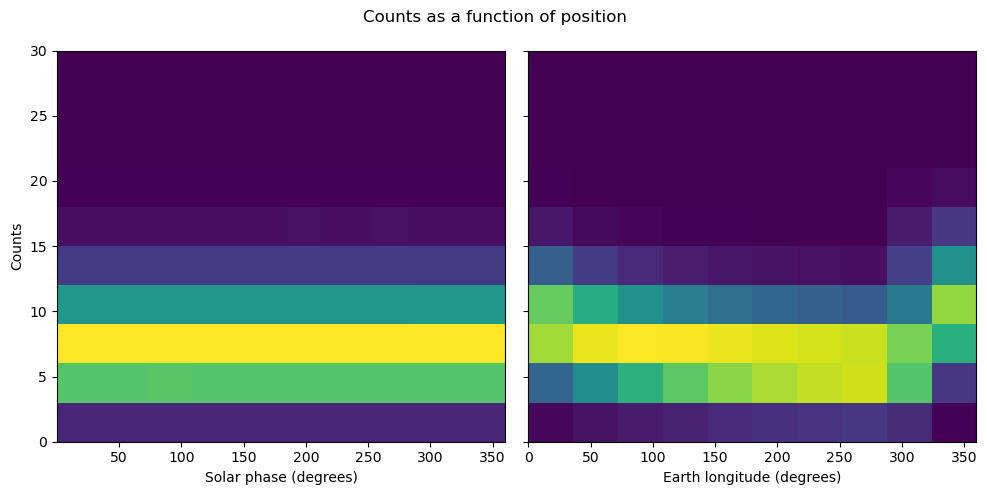

In [11]:
fig, ax = plt.subplots(1,2, figsize=(10,5), sharey=True)
ax[0].hist2d(data[1,:], data[3,:])
ax[1].hist2d(data[2,:], data[3,:])
ax[0].set_ylabel('Counts')
ax[0].set_xlabel('Solar phase (degrees)')
ax[1].set_xlabel('Earth longitude (degrees)')
plt.suptitle('Counts as a function of position')
plt.tight_layout()
plt.show()

Here, it's much more clear how the background distribution changes with time. Solar phase does not seem to have any impact on counts, but Earth longitude does. As the background changes with the angle, this means the mean of the Poisson distribution changes with the angle as well.

#### 3)

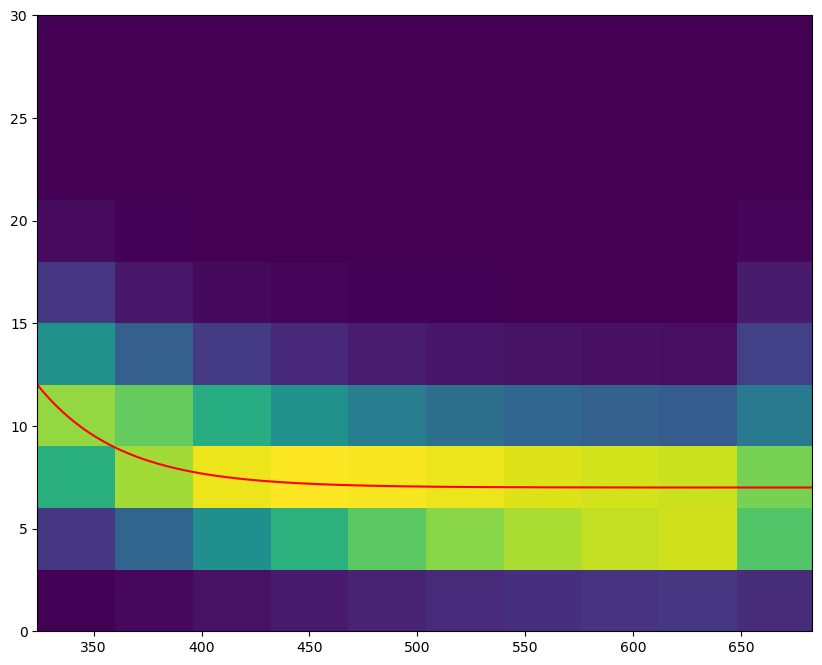

In [40]:
x0 = 324
A = 5
k = 1.5
C = 7
r = 2*np.pi/360 # convert degrees to radians

x = np.linspace(x0, 360+x0, 1000)

plt.hist2d(data[2,:], data[3,:])
plt.hist2d(data[2,:]+360, data[3,:])
plt.xlim(324,683)
plt.plot(x, A*np.exp(-k*r*(x-x0))+C,c='r', label='Exponential function')
plt.show()


After shifting the phase of the counts vs longitude plot, we can see that a function that roughly matches the mean of the distribution as a function of angle is an exponential function in the form $f(\theta) = Ae^{-k\theta}+C$. The values $A=5$, $k=1.5$ and $C=7$ give a good approximation of the distribution of the background as a function of Earth longitude.

#### 4)

### Problem 2.

#### 1)

In [13]:
stars_file = h5py.File('images.h5', 'r')
stars_file.keys()

<KeysViewHDF5 ['image1', 'imagestack']>

In [14]:
stars = np.array(stars_file.get('imagestack'))

#### 2) 
First, I'll a plot the data to inspect it.

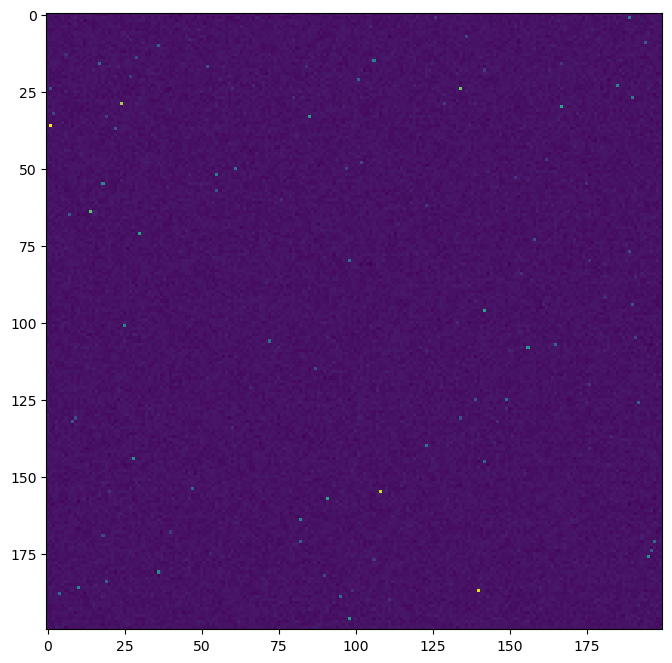

In [15]:
plt.imshow(stars[:,:,6])

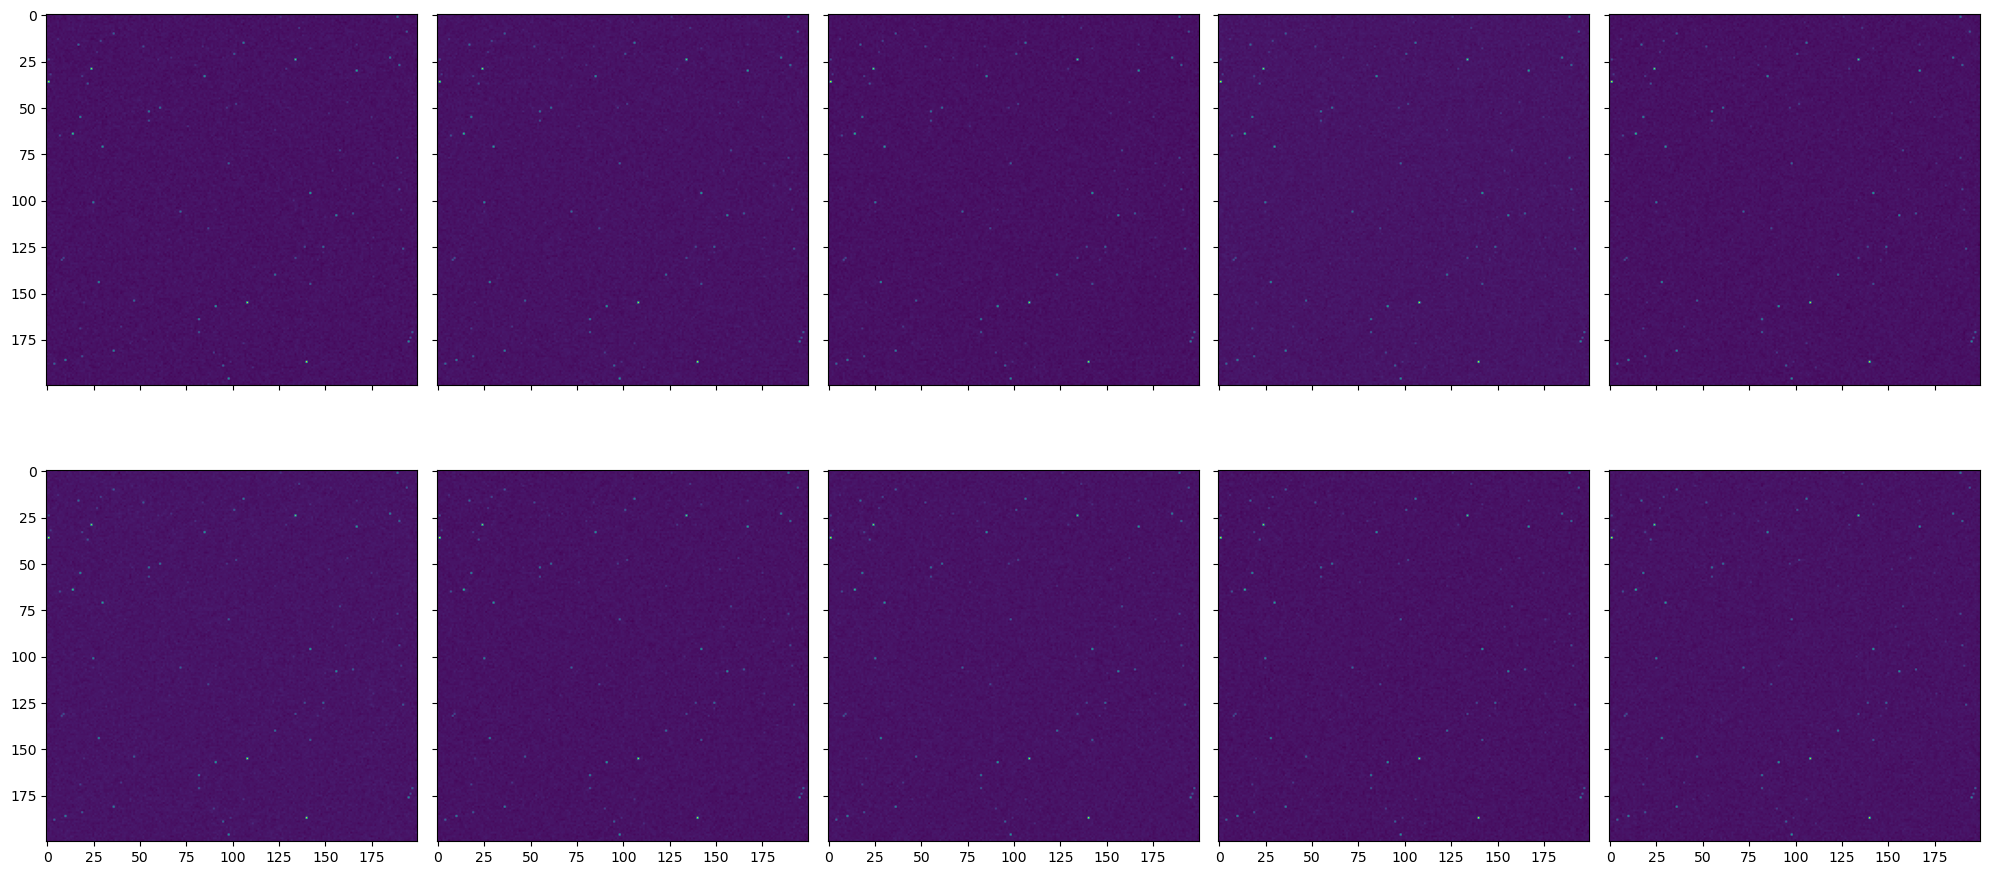

In [16]:
fig, ax = plt.subplots(2,5, figsize=(20,10), sharex=True, sharey=True)
for i in range(0,5):
    ax[0,i].imshow(stars[:,:,i])
for i in range(0,5):
    ax[1,i].imshow(stars[:,:,i+5])
plt.tight_layout()

There doesn't appear to be any data contamination, like obvious cosmic rays or other artifacts.

To see if there is time dependence, I'll look along one axis and see if it changes. We should expect to see a distribution that is the background, with some additional counts in the higher values corresponding to the stars. If the background doesn't change in time, then the central distribution should stay roughly the same.

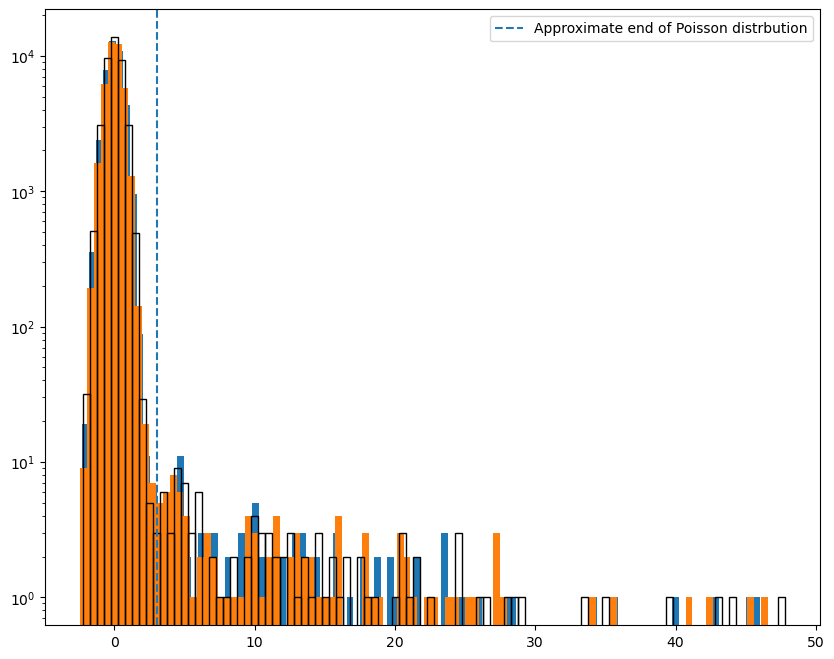

In [17]:
x = np.arange(0,200)
one_d = []

for i in range(0,10):
    image = []
    for j in range(0,200):
        for k in range(0,200):
            image.append(stars[j,k,i])
    one_d.append(image)
    
plt.hist(one_d[0], bins=100)
plt.hist(one_d[1], bins=100)
plt.hist(one_d[2], bins=100, fill=False)
plt.axvline(3, linestyle='--', label='Approximate end of Poisson distrbution')
plt.yscale('log')
plt.legend()
plt.show()

We can see here that just about every part of the distribution is changing with time, though the background doesn't change a very large amount. To find the final background pdf(), I will exclude higher values to remove the stars, then I will convolve and average the backgrounds. From above, it appears that counts above about 3 should be excluded from the background distribution.

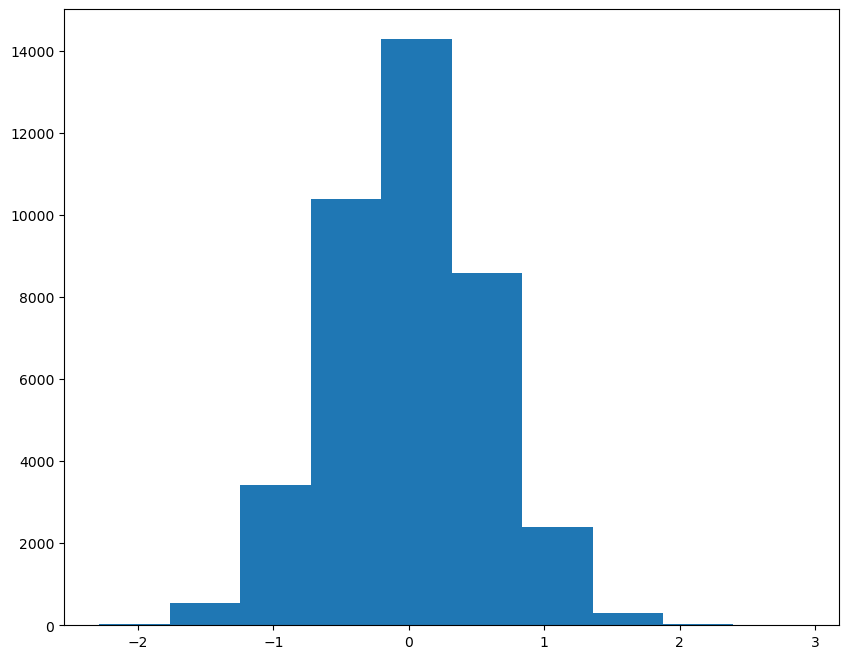

In [18]:
bkg = one_d[0]

# remove higher values to cut out stars
for i in range(len(bkg)):
    if bkg[i] > 3:
        bkg[i] = 0

for j in range(1,10):
    bkg2 = one_d[j]
    for i in range(len(bkg2)):
        if bkg2[i] > 3:
            bkg2[i] = 0
    np.convolve(bkg,bkg2)
plt.hist(bkg)
plt.show()